In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

At the end of January, Tranmere were second in League Two. They ended the season in ninth. The purpose of this project is to put some hard data behind that demise.

Specifically, I sought to understand:

* How did the frequency with which Tranmere kept clean sheets in away game change after February 1?
* How did Tranmere's points-per-game average alter after February 1?
* In which minutes did Tranmere tend to concede most goals?
* How did Tranmere perform against the best, worst and middling teams?

### DATA SOURCES
This notebook begins with the same dataset I used for my [Friday night football project](https://github.com/petebrown/friday-night-football/blob/main/notebook/friday-night-football-analysis.ipynb).

I acquired the data for this analysis from two websites:

* Results data was scraped from 11v11.com.
* Manager data (name, start date and end date) was scraped from Soccerbase.

These two datasets were joined together to create the csv used in this analysis, `results.csv`.

This dataset contains information about all games played between 1921/22 and 2021/22.

## ANALYSIS

This analysis focuses solely on league matches played in the 2021/22 season, so the dataframe is filtered accordingly.

In [2]:
df = pd.read_csv('results.csv', parse_dates=['game_date'])

df['month'] = df.game_date.dt.month

df = df[(df.season == '2021/22') & (df.competition == 'League Two')]

df = df.sort_values('game_date')

The questions asked in this analysis require information not currently in the dataframe.

Specifically:

* `points`: The number of points won in each game
* `total_pts_cumsum`: The running total of points won after each game
* `venue_pts_cumsum`: The running total of points won after each game by venue (i.e. running total for home games and running total for away games)
* `game_no`: Running count of the game number for each game
* `venue_game_no`: Running count of  of game number for each game by venue
* `ppg_venue`: The running average of mean points per game by venue

In [3]:
df['points'] = df.apply(lambda x: 3 if x['outcome'] == 'W' else (1 if x['outcome'] == 'D' else 0), axis = 1)

df['total_pts_cumsum'] = df.groupby(['season'])['points'].cumsum()

df['venue_pts_cumsum'] = df.groupby(['season', 'venue'])['points'].cumsum()

df['game_no'] = df.groupby(['season']).cumcount() + 1

df['venue_game_no'] = df.groupby(['season', 'venue']).cumcount() + 1

df['ppg_venue'] = df.venue_pts_cumsum / df.venue_game_no

### Understanding how clean sheets dried up in away games

The first objective was to understand how Tranmere's ability to keep clean sheets (not concede a goal in a game) deserted them over the course of the season.

To achieve this, I created a column that returns a `1` for games where `df.goals_against` was zero and `0` if a goal was conceded. `df` was then filtered for away games.

<AxesSubplot:xlabel='venue_game_no'>

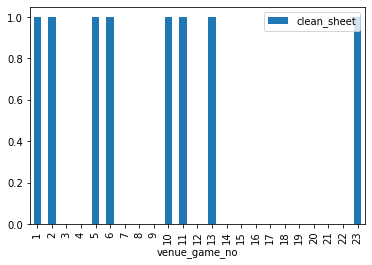

In [4]:
df['clean_sheet'] = df.apply(lambda x: 1 if x.goals_against == 0 else 0, axis = 1)

df[(df.season == '2021/22') & (df.venue == 'A')].plot.bar(x = 'venue_game_no', y = 'clean_sheet')

In [5]:
# Export the the little dataset needed for Datawrapper

clean_sheets_csv = df[(df.season == '2021/22') & (df.venue == 'A')][['venue_game_no', 'clean_sheet']]

clean_sheets_csv.to_csv('clean_sheets.csv', index = False)

### Charting points-per-game by venue over the course of the season

All of the setup for this happened at the outset of this notebook.

The output demonstrates how Tranmere's home form remained consistent, but away form diminished.

venue
A    AxesSubplot(0.125,0.125;0.775x0.755)
H    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

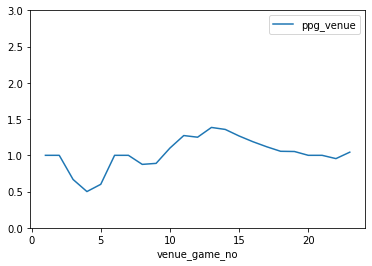

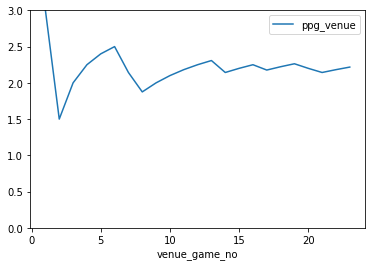

In [6]:
df[['venue', 'venue_game_no', 'ppg_venue']].groupby('venue').plot(x = 'venue_game_no', y = 'ppg_venue', ylim = (0, 3))

In [7]:
# Export small datasets for use with Datawrapper

ppg_home = df[df.venue == 'H'][['venue_game_no', 'ppg_venue']]
ppg_away = df[df.venue == 'H'][['venue_game_no', 'ppg_venue']]

ppg_home.to_csv('ppg_home_games.csv', index=False)
ppg_away.to_csv('ppg_away_games.csv', index=False)

## Scraping goal minute data from Soccerbase

The main dataset does not contain data about the minutes in which goals were conceded.

I therefore scraped the required data from Soccerbase.

Game data appears in a Javascript popup in Soccerbase, but I was able to find a scrapable URL via the Network tab.

The resulting dataframe – named `events_df` - contains data about every event in each game (e.g. goal, red card, etc.)

In [8]:
game_ids = ['tgc830059', 'tgc830627', 'tgc830067', 'tgc830082', 'tgc830095', 'tgc830104', 'tgc830119', 'tgc830126', 'tgc838131', 'tgc830143', 'tgc830146', 'tgc830167', 'tgc838157', 'tgc830178', 'tgc830181', 'tgc830196', 'tgc830214', 'tgc830222', 'tgc840348', 'tgc838186', 'tgc830238', 'tgc830242', 'tgc830263', 'tgc840683', 'tgc830285', 'tgc830291', 'tgc830311', 'tgc840979', 'tgc830323', 'tgc830359', 'tgc830343', 'tgc830371', 'tgc830373', 'tgc830395', 'tgc830275', 'tgc830396', 'tgc830419', 'tgc830431', 'tgc830328', 'tgc830443', 'tgc830450', 'tgc830464', 'tgc830478', 'tgc830490', 'tgc830503', 'tgc830506', 'tgc830526', 'tgc830539', 'tgc830541', 'tgc830563', 'tgc830574', 'tgc830587', 'tgc830594']

ignore_list = ['tgc830627', 'tgc840348', 'tgc840683', 'tgc838131', 'tgc838157', 'tgc838186', 'tgc840979']

events = []

for game_id in game_ids:
    
    if game_id not in ignore_list:
    
        game_id = game_id.replace('tgc', '')

        url = f'https://www.soccerbase.com/matches/additional_information.sd?id_game={game_id}'

        r = requests.get(url)

        bs = BeautifulSoup(r.text)

        match = bs.select_one('p.score').text.strip()

        home_team = str(bs.select_one('p.score .teamA')).split(' <')[0].split('> ')[1]
        away_team = str(bs.select_one('p.score .teamB')).split(' <')[0].split('> ')[1]

        home_score = int(bs.select_one('p.score .teamA em').text)
        away_score = int(bs.select_one('p.score .teamB em').text)

        home_events = bs.select('div.goalscorers .teamA span')
        away_events = bs.select('div.goalscorers .teamB span')

        for event in home_events:
            event_info = event.text
            try:
                event_type = event['class'][0]
            except:
                event_type = 'goal'
                
            goals = event_info.split(',')
            
            for goal in goals:
                
                data = {'match': match,
                        'home_team': home_team,
                        'away_team': away_team,
                        'event_team': home_team,
                        'event': goal.strip(),
                        'event_type': event_type}
                events.append(data)

        for event in away_events:
            event_info = event.text
            try:
                event_type = event['class'][0]
            except:
                event_type = 'goal'
                
            goals = event_info.split(',')
            
            for goal in goals:
                
                data = {'match': match,
                        'home_team': home_team,
                        'away_team': away_team,
                        'event_team': away_team,
                        'event': goal.strip(),
                        'event_type': event_type}
                events.append(data)

events_df = pd.DataFrame(events)

events_df.head()

,match,home_team,away_team,event_team,event,event_type
0,Tranmere 1-0 Walsall,Tranmere,Walsall,Tranmere,Callum McManaman (73),goal
1,Tranmere 1-0 Walsall,Tranmere,Walsall,Tranmere,Chris Merrie (s/o 86),sendingOffPlayer
2,Tranmere 0-1 Newport Co,Tranmere,Newport Co,Newport Co,Alex Fisher (60),goal
3,Scunthorpe 1-0 Tranmere,Scunthorpe,Tranmere,Scunthorpe,Myles Hippolyte (pen 4),goal
4,Tranmere 1-0 Hartlepool,Tranmere,Hartlepool,Tranmere,Tom Davies (89),goal


The question focuses solely on goals conceded, so a dedicated dataframe named `goals_against` is produced.

In [9]:
events_df['minute'] = events_df.event.str.extract('(\d+)').astype('int')

events_df['minute_range'] = pd.cut(events_df['minute'], [0, 11, 21, 31, 41, 51, 61, 71, 81, 90], labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'])

events_df['half_scored'] = events_df.apply(lambda x: 'first half' if x.minute <= 45 else 'second half', axis = 1)

In [10]:
goals_against = events_df[(events_df.event_team != 'Tranmere') & (events_df.event_type == 'goal')]

goals_against.head()

,match,home_team,away_team,event_team,event,event_type,minute,minute_range,half_scored
2,Tranmere 0-1 Newport Co,Tranmere,Newport Co,Newport Co,Alex Fisher (60),goal,60,51-60,second half
3,Scunthorpe 1-0 Tranmere,Scunthorpe,Tranmere,Scunthorpe,Myles Hippolyte (pen 4),goal,4,0-10,first half
5,Rochdale 1-0 Tranmere,Rochdale,Tranmere,Rochdale,Danny Cashman (84),goal,84,81-90,second half
13,Tranmere 2-1 Crawley,Tranmere,Crawley,Crawley,Kwesi Appiah (64),goal,64,61-70,second half
17,Harrogate 2-2 Tranmere,Harrogate,Tranmere,Harrogate,Jack Muldoon (pen 39),goal,39,31-40,first half


<AxesSubplot:>

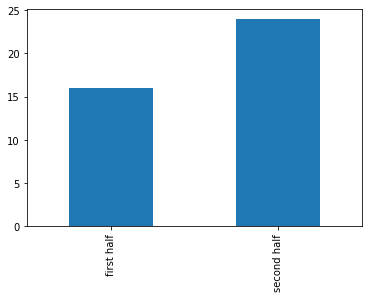

In [11]:
# Eye-balling goals conceded by half

goals_against.half_scored.value_counts().sort_index().plot(kind='bar')

<AxesSubplot:>

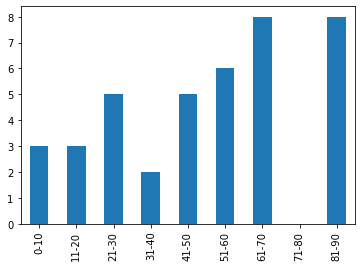

In [12]:
# Eyeballing goals conceded in each ten-minute period of games

goals_against.minute_range.value_counts().sort_index().plot(kind="bar")

<AxesSubplot:>

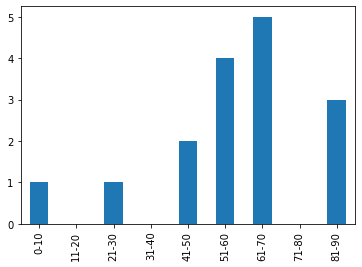

In [13]:
# Eyeballing goals conceded in each ten-minute period of HOME games

goals_against[goals_against.home_team == 'Tranmere'].minute_range.value_counts().sort_index().plot(kind="bar")

<AxesSubplot:>

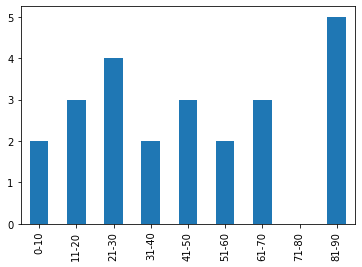

In [14]:
# Eyeballing goals conceded in each ten-minute period of AWAY games

goals_against[goals_against.away_team == 'Tranmere'].minute_range.value_counts().sort_index().plot(kind="bar")

### Understanding Rovers' away record against teams that finished in the top, middle and bottom positions

To answer this question I needed data about each team's final league position.

I had this is another CSV, scraped from 11v11.com – `league_tables.csv`

By joining this CSV with the existing `df`, we are able to break point hauls down by league groupings.

Given that the league contains 24 teams, they separated into three groups of eight:

* Top eight
* Mid-table
* Bottom eight

In [15]:
league_tables = pd.read_csv('league_tables.csv')

l2_table = league_tables.query("season == '2021/22' & table == 'home_and_away'")[['team', 'league_position']].rename(columns = {'team': 'opposition'})

In [16]:
df = df.merge(l2_table, how = 'left', on = 'opposition')

df['league_group'] = df.apply(lambda x: 'top_eight' if x.league_position <= 8 else ('bottom_eight' if x.league_position > 16 else 'middle eight'), axis = 1)

df[df['season'] == '2021/22'].groupby(['league_group', 'venue'])['points'].mean().unstack()

venue,A,H
league_group,,
bottom_eight,1.000000,2.750000
middle eight,1.142857,2.571429
top_eight,1.000000,1.375000


<AxesSubplot:xlabel='league_group'>

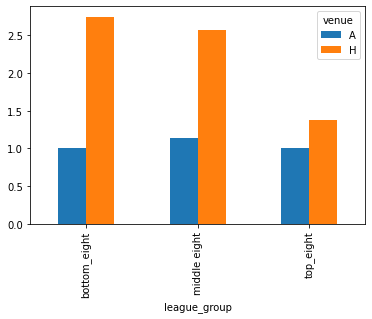

In [17]:
df[df['season'] == '2021/22'].groupby(['league_group', 'venue'])['points'].mean().unstack().plot(kind="bar")